<a href="https://colab.research.google.com/github/ilEnzio/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/ERLE_GRANGERII_DS18_LS_DS_221_assignment_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [497]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [498]:
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split


# special sauce for custom method :) 
from collections import namedtuple

# ML models
from sklearn.linear_model import LinearRegression # old reliable model, for continous
from sklearn.linear_model import Ridge # RidgeRegression to guard against overfit
from sklearn.linear_model import LogisticRegression # used to predict categorical vectors


# Metric accessing functions
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Transformers
from category_encoders import OneHotEncoder # splits cat variable 
from sklearn.feature_selection import SelectKBest # selects highest correlating features
from sklearn.impute import SimpleImputer

# Lets us combine the steps for cleaner code
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [499]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [500]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

## Start to build my Wrangle Function

#### construction year - change 0 to nan


In [501]:
def wrangle_water_pump_comp(df):
  year = ["construction_year"]
  for x in year:
    df[x] = df[x].replace(0, np.nan)

  return df

In [503]:
train_original = train.copy()

In [504]:
year = train_df["construction_year"]
year.head()

0    1999.0
1    2010.0
2    2009.0
3    1986.0
4       NaN
Name: construction_year, dtype: float64

In [481]:
train_df.construction_year.value_counts()



2010.0    2645
2008.0    2613
2009.0    2533
2000.0    2091
2007.0    1587
2006.0    1471
2003.0    1286
2011.0    1256
2004.0    1123
2012.0    1084
2002.0    1075
1978.0    1037
1995.0    1014
2005.0    1011
1999.0     979
1998.0     966
1990.0     954
1985.0     945
1996.0     811
1980.0     811
1984.0     779
1982.0     744
1994.0     738
1972.0     708
1974.0     676
1997.0     644
1992.0     640
1993.0     608
2001.0     540
1988.0     521
1983.0     488
1975.0     437
1986.0     434
1976.0     414
1970.0     411
1991.0     324
1989.0     316
1987.0     302
1981.0     238
1977.0     202
1979.0     192
1973.0     184
2013.0     176
1971.0     145
1960.0     102
1967.0      88
1963.0      85
1968.0      77
1969.0      59
1964.0      40
1962.0      30
1961.0      21
1965.0      19
1966.0      17
Name: construction_year, dtype: int64

In [505]:
#get rid of the construction year zeros... 
train= wrangle_water_pump_comp(train)
test = wrangle_water_pump_comp(test)

In [506]:
train_df = train.copy()
test_df = test.copy()

In [507]:
test_df.shape

(14358, 40)

In [494]:
test.construction_year.value_counts()

2010.0    2645
2008.0    2613
2009.0    2533
2000.0    2091
2007.0    1587
2006.0    1471
2003.0    1286
2011.0    1256
2004.0    1123
2012.0    1084
2002.0    1075
1978.0    1037
1995.0    1014
2005.0    1011
1999.0     979
1998.0     966
1990.0     954
1985.0     945
1996.0     811
1980.0     811
1984.0     779
1982.0     744
1994.0     738
1972.0     708
1974.0     676
1997.0     644
1992.0     640
1993.0     608
2001.0     540
1988.0     521
1983.0     488
1975.0     437
1986.0     434
1976.0     414
1970.0     411
1991.0     324
1989.0     316
1987.0     302
1981.0     238
1977.0     202
1979.0     192
1973.0     184
2013.0     176
1971.0     145
1960.0     102
1967.0      88
1963.0      85
1968.0      77
1969.0      59
1964.0      40
1962.0      30
1961.0      21
1965.0      19
1966.0      17
Name: construction_year, dtype: int64

## EDA
From the profile alone and the data Dictionary I think I would like to start with an MVP model that includes:


* amount_tsh : Total static head (amount water available to waterpoint)
* construction_year : Year the waterpoint was constructed
* water_quality : The quality of the water
* quantity : The quantity of water



```
# This is formatted as code
```



In [460]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   construction_year  38691 non-null  float64
 2   quantity           59400 non-null  object 
 3   extraction_type    59400 non-null  object 
 4   region             59400 non-null  object 
 5   gps_height         59400 non-null  int64  
 6   status_group       59400 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 3.6+ MB


## Contruction Year goes to datetime? let me check it...

In [508]:
train_df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [509]:
train_df['construction_year'].value_counts()

2010.0    2645
2008.0    2613
2009.0    2533
2000.0    2091
2007.0    1587
2006.0    1471
2003.0    1286
2011.0    1256
2004.0    1123
2012.0    1084
2002.0    1075
1978.0    1037
1995.0    1014
2005.0    1011
1999.0     979
1998.0     966
1990.0     954
1985.0     945
1996.0     811
1980.0     811
1984.0     779
1982.0     744
1994.0     738
1972.0     708
1974.0     676
1997.0     644
1992.0     640
1993.0     608
2001.0     540
1988.0     521
1983.0     488
1975.0     437
1986.0     434
1976.0     414
1970.0     411
1991.0     324
1989.0     316
1987.0     302
1981.0     238
1977.0     202
1979.0     192
1973.0     184
2013.0     176
1971.0     145
1960.0     102
1967.0      88
1963.0      85
1968.0      77
1969.0      59
1964.0      40
1962.0      30
1961.0      21
1965.0      19
1966.0      17
Name: construction_year, dtype: int64

In [510]:
# I should replace these zeros w/ Nan then impute them with or mode?
print(train_df.construction_year.mode())
print(train_df.construction_year.mean())

0    2010.0
dtype: float64
1996.8146855857951


In [464]:
cond_nzero = train_df['construction_year'] != 0
cond_nzero

0        True
1        True
2        True
3        True
4        True
         ... 
59395    True
59396    True
59397    True
59398    True
59399    True
Name: construction_year, Length: 59400, dtype: bool

In [465]:
# temp_1 = train_df[cond_nzero]
print(temp_1.construction_year.mean())
print(temp_1.construction_year.mode())
print(temp_1.construction_year.median())

1996.8146855857951
0    2010.0
dtype: float64
2000.0


In [466]:
train_df['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [511]:
train_df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

### Create the X-Matrix using 

  * 'construction_year' 
  * 'water_quality'
  * 'quantity'
  * 'amount_tsh'

### Y Target 
  * 'status_group'


In [512]:
column_list =  ['amount_tsh', "construction_year",
                     'water_quality', 'quantity', 'status_group']

In [513]:
train_df = train_df[column_list]
train_df.shape

(59400, 5)

### I will be OHE - 'water_quality', 'quantity'

### Split Data

In [514]:
# create Matrix and target
y_target = train_df['status_group']
X_matrix = train_df.drop('status_group', axis=1)

In [515]:
# Make a function to create Matrix and Target pre validation split
def create_Xmatrix_ytarget(train_df):
  y_target = train_df['status_group']
  X_matrix = train_df.drop('status_group', axis=1)
  return (X_matrix, y_target)


In [517]:
X_matrix.shape

(59400, 4)

In [518]:
y_target.shape

(59400,)

In [519]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_matrix, y_target,
                                                  test_size=.2, random_state=42)

In [520]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(47520, 4)
(11880, 4)
(47520,)
(11880,)


### Get a Baseline Metric 
## For Classification will take the Majority Classifier (Accuracy)


In [521]:
train['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

# Build a Model : Decision Tree Classifier

### Pipeline first

**tree model01** = 'amount_tsh', "construction_year",
                     'water_quality', 'quantity'

**Max Depth**  = 14

This is a decision tree MVP.  
it recieved a Accuracy Score of :
* Training Accuracy: 0.6993265993265994
* **Validation Accuracy: 0.685942760942761**

In [522]:
from sklearn.tree import DecisionTreeClassifier

tree_model01 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(criterion="entropy", max_depth=14, random_state=42)
)

tree_model01.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['water_quality', 'quantity'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=14,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                   

In [523]:
print(f"Training Accuracy: {tree_model01.score(X_train, y_train)}")
print(f"Validation Accuracy: {tree_model01.score(X_val, y_val)}")

      

Training Accuracy: 0.6993265993265994
Validation Accuracy: 0.685942760942761


In [524]:
classifier = tree_model01.named_steps['decisiontreeclassifier']
feature_names = tree_model01.named_steps['onehotencoder'].feature_names

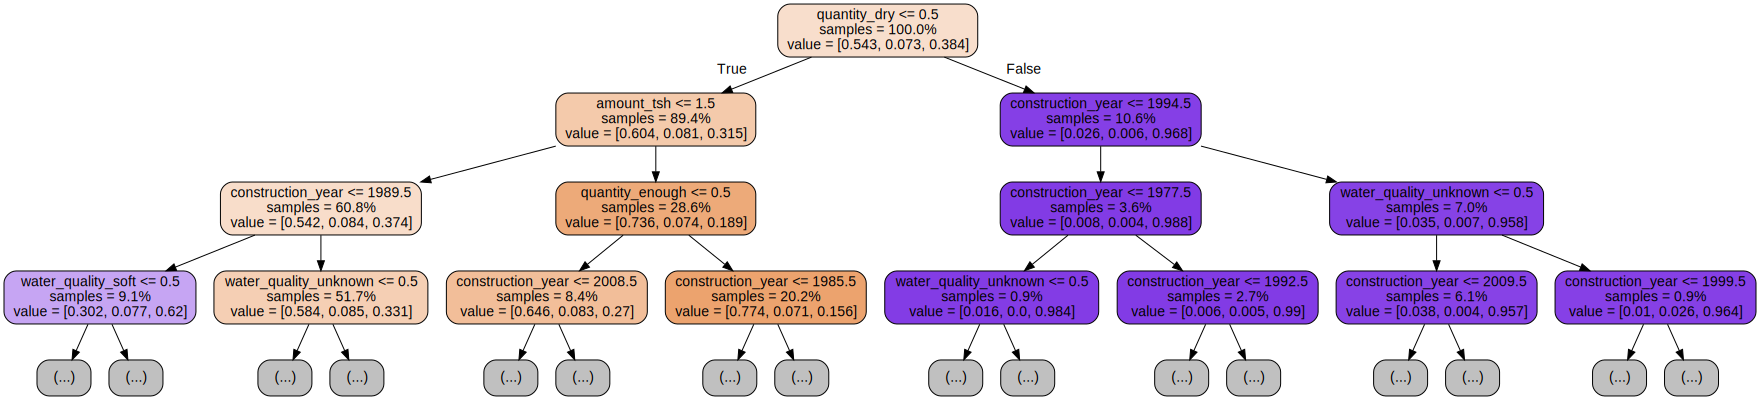

In [525]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(classifier, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=feature_names,
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

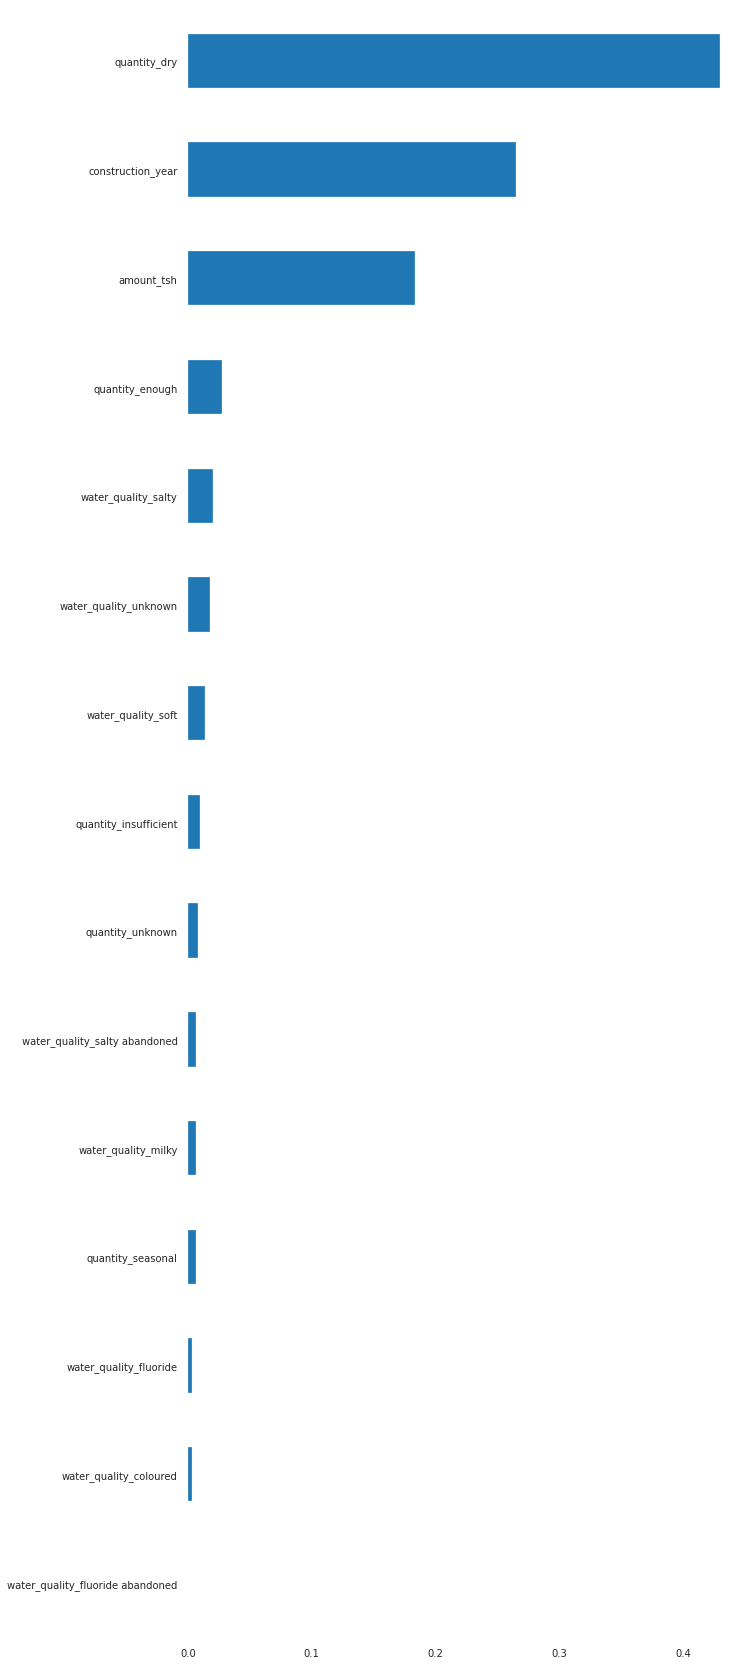

In [526]:
import matplotlib.pyplot as plt

feat_importances = classifier.feature_importances_
importances = pd.Series(feat_importances, index=feature_names)

plt.figure(figsize=(10,30))
importances.sort_values().plot(kind='barh');

In [527]:
 column_list2 =  ['amount_tsh', "construction_year",
                     'water_quality', 'quantity'] 

In [528]:
test_tree_01 = test[column_list2]

In [529]:
y_pred_tree_01=tree_model01.predict(test_tree_01)

In [530]:
y_pred_tree_01.shape

(14358,)

In [531]:
sample_submission.shape

(14358, 2)

In [532]:
sample_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [533]:
sub_tree_01 = sample_submission.copy()

In [534]:
sub_tree_01["status_group"] = y_pred_tree_01
sub_tree_01.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [535]:
sub_tree_01.to_csv("sub_tree_01.csv", index = False)

## Submission export Function

In [536]:
def get_sub_csv(prediction, name_string):
  # copy the sample and replace the target vector
  # with the prediction array
  temp_df = sample_submission.copy()
  temp_df["status_group"] = prediction

  temp_df.to_csv(name_string+".csv", index= False)


In [537]:
# test the function 
get_sub_csv(y_pred_tree_01, "test01")

### Logistic Regression Pipeline 


In [538]:
log_reg_model_01 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LogisticRegression()
)

log_reg_model_01.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['water_quality', 'quantity'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lb

**log_reg_model_01** = 'amount_tsh', "construction_year",
                     'water_quality', 'quantity'

This is a decision tree MVP.  
it recieved a Accuracy Score of :
* Training Accuracy: 0.6496843434343434
* **Validation Accuracy: 0.6460437710437711**

In [539]:
print('Training Accuracy:', log_reg_model_01.score(X_train, y_train))
print('Validation Accuracy:', log_reg_model_01.score(X_val, y_val))

Training Accuracy: 0.6496843434343434
Validation Accuracy: 0.6460437710437711


In [ ]:
y_pred_log_reg_model_01=log_reg_model_01.predict(test_tree_01)

In [ ]:
get_sub_csv(y_pred_log_reg_model_01, "sub_log_reg_model_01")

## **tree model_02** 

    = 'amount_tsh', "construction_year",
                'quantity','extraction_type',
                 'region',"gps_height"

**Max Depth**  = 15

This is a decision tree MVP.  
it recieved a Accuracy Score of :
* Training Accuracy: 0.7780513468013468
* **Validation Accuracy: 0.7388047138047138**

In [540]:
column_list_rn2 =  ['amount_tsh', "construction_year",
                'quantity','extraction_type',
                 'region',"gps_height", 'status_group']

In [541]:
train["region"].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [ ]:
train['extraction_type'].value_counts()

In [542]:
train_df = train[column_list_rn2]
train_df.shape

(59400, 7)

In [543]:
X_matrix, y_target = create_Xmatrix_ytarget(train_df)
print(X_matrix.shape)
print(y_target.shape)

(59400, 6)
(59400,)


In [544]:
X_train, X_val, y_train, y_val = train_test_split(X_matrix, y_target,
                                                  test_size=.2, random_state=42)

In [545]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(47520, 6)
(11880, 6)
(47520,)
(11880,)


In [546]:
tree_model_02 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(criterion="entropy", max_depth=15, random_state=42)
)

tree_model_02.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['quantity', 'extraction_type', 'region'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=15,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                       

In [547]:
print(f"Training Accuracy: {tree_model_02.score(X_train, y_train)}")
print(f"Validation Accuracy: {tree_model_02.score(X_val, y_val)}")


Training Accuracy: 0.7780513468013468
Validation Accuracy: 0.7388047138047138


In [548]:
column_list_rn2b =  ['amount_tsh', "construction_year",
                'quantity','extraction_type',
                 'region',"gps_height"]

In [549]:
test_tree_02 = test[column_list_rn2b]
# test_tree_02.head()

In [550]:
y_pred_tree_model_02 = tree_model_02.predict(test_tree_02)


In [551]:
get_sub_csv(y_pred_tree_model_02, "sub_tree_02")

In [552]:
classifier2 = tree_model_02.named_steps['decisiontreeclassifier']
feature_names2 = tree_model_02.named_steps['onehotencoder'].feature_names

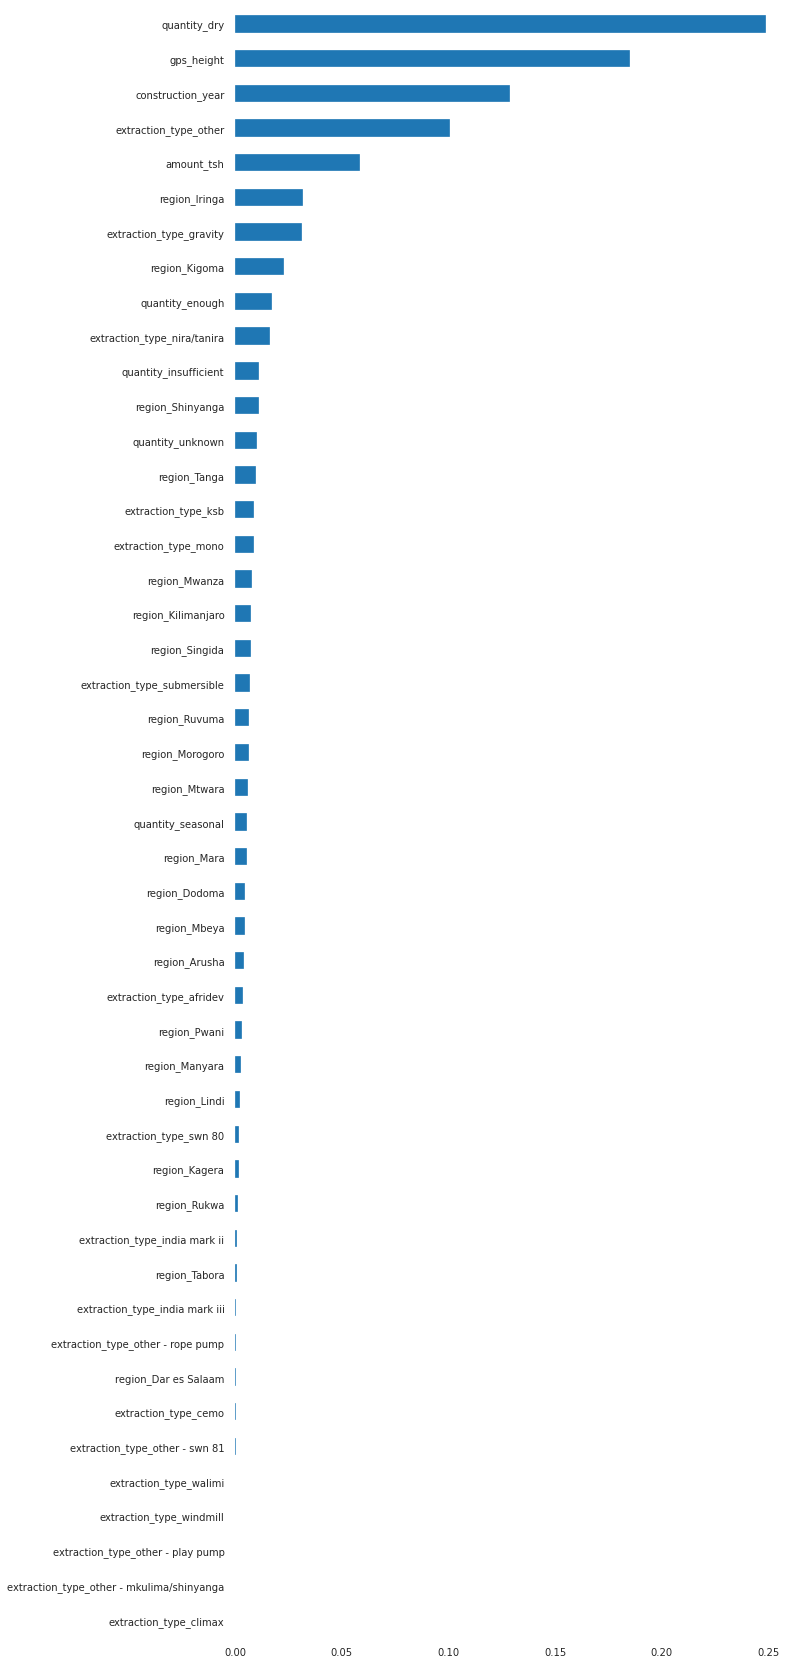

In [553]:
feat_importances = classifier2.feature_importances_
importances = pd.Series(feat_importances, index=feature_names2)

plt.figure(figsize=(10,30))
importances.sort_values().plot(kind='barh');

In [554]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [556]:
train.population.nunique()

1049

In [558]:
train.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.004165
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.006331
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,-0.006244
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.028082
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,0.038547
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,-0.003250
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,-0.009755
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.007518
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.032544
construction_year,-0.004165,0.006331,-0.006244,0.028082,0.038547,-0.003250,-0.009755,0.007518,0.032544,1.000000


## **tree model_03** 

    = 'amount_tsh', "construction_year",
                'quantity','extraction_type',
                 'region',"gps_height", "population"

**Max Depth**  = 18

This is a decision tree MVP.  
it recieved a Accuracy Score of :
* Training Accuracy: 0.8174452861952862
* **Validation Accuracy: 0.740909090909091**

In [598]:
column_list_rn3 =  ['amount_tsh', "construction_year",
                'quantity','extraction_type',
                 'region',"gps_height","population",
                 "status_group"]

In [599]:
train_df = train[column_list_rn3]
train_df.shape

(59400, 8)

In [600]:
X_matrix, y_target = create_Xmatrix_ytarget(train_df)
print(X_matrix.shape)
print(y_target.shape)

(59400, 7)
(59400,)


In [601]:
X_train, X_val, y_train, y_val = train_test_split(X_matrix, y_target,
                                                  test_size=.2, random_state=42)

In [602]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(47520, 7)
(11880, 7)
(47520,)
(11880,)


In [603]:
tree_model_03 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    DecisionTreeClassifier(criterion="entropy", max_depth=18, random_state=42)
)

tree_model_03.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['quantity', 'extraction_type', 'region'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=18,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                       

In [604]:
print(f"Training Accuracy: {tree_model_03.score(X_train, y_train)}")
print(f"Validation Accuracy: {tree_model_03.score(X_val, y_val)}")


Training Accuracy: 0.8174452861952862
Validation Accuracy: 0.740909090909091


In [605]:
classifier3 = tree_model_03.named_steps['decisiontreeclassifier']
feature_names3 = tree_model_03.named_steps['onehotencoder'].feature_names

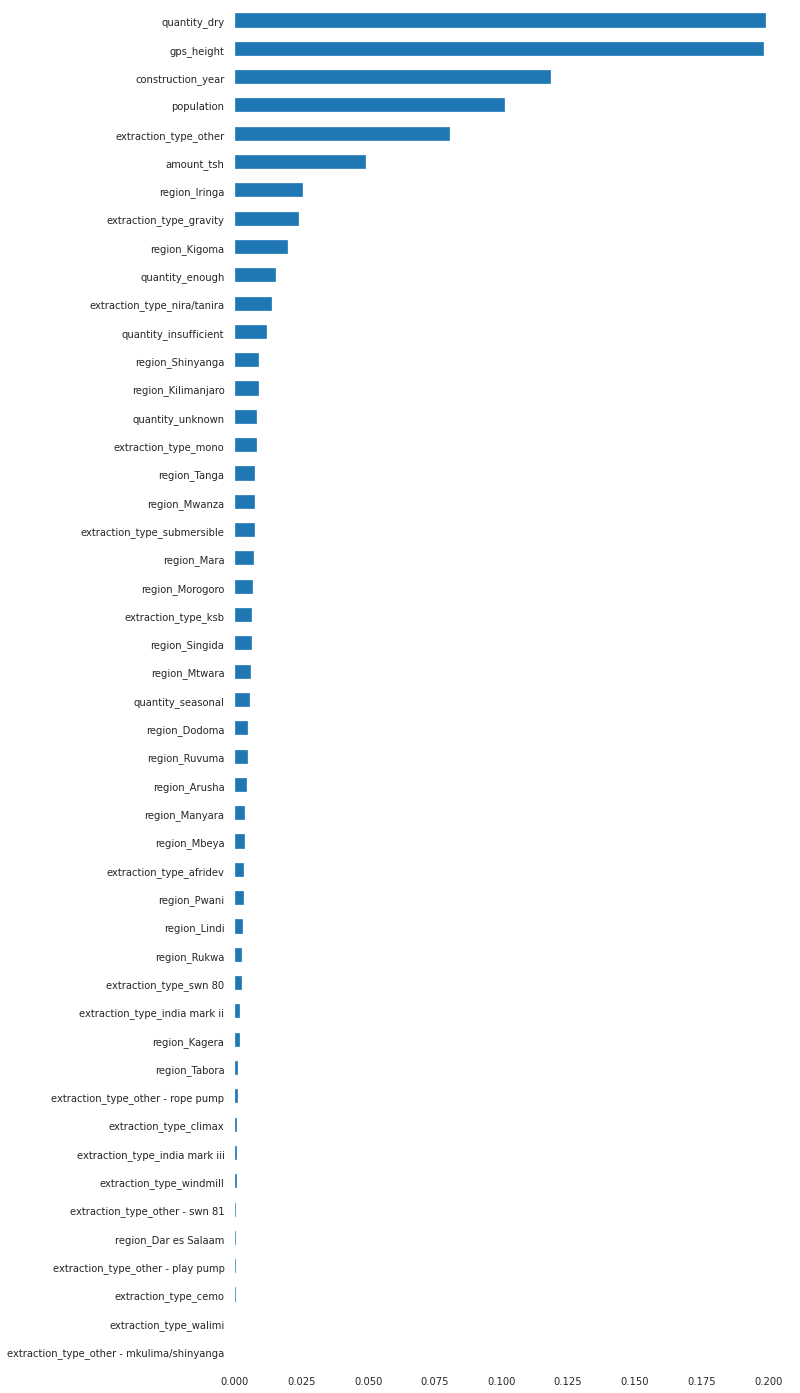

In [606]:
feat_importances = classifier3.feature_importances_
importances = pd.Series(feat_importances, index=feature_names3)

plt.figure(figsize=(10,25))
importances.sort_values().plot(kind='barh');

In [607]:
column_list_rn3b =  ['amount_tsh', "construction_year",
                'quantity','extraction_type',
                 'region',"gps_height", "population"]

In [608]:
test_tree_03 = test[column_list_rn3b]
# test_tree_02.head()

In [609]:
y_pred_tree_model_03 = tree_model_03.predict(test_tree_03)


In [610]:
get_sub_csv(y_pred_tree_model_03, "sub_tree_03")